In [ ]:
import numpy as np
import pysindy as ps
from pysindy.feature_library import PolynomialLibrary, FourierLibrary, CustomLibrary, ConcatLibrary
import matplotlib.pyplot as plt

from decimal import Decimal
from generate_data import generate_population_data, generate_discrete_population_data

In [ ]:
t = np.linspace(0, 100, 1001)

x0 = [50, 50]
x0_val = [100, 30]
sterowanie = 2

u = lambda t : np.sin(t)
u_val = lambda t : np.cos(2*t)

In [ ]:
x, x_dot = generate_population_data(t, x0, u)
x_val, _ = generate_population_data(t, x0_val, u_val)

In [ ]:
T = 1e-2
xk = generate_discrete_population_data(t, x0, T=T, u=u(t))
xk_val = generate_discrete_population_data(t, x0_val, T=T, u=u_val(t))

In [ ]:
pr = int(3 - np.log10(T))
model = ps.SINDy(
    feature_library=PolynomialLibrary(degree=2), # 2, 1
    # feature_library=FourierLibrary(n_frequencies=2), # 2, 1
    optimizer=ps.STLSQ(threshold=0.00001), # 0.001, 0.01, 0.1
    feature_names=[f'x{i+1}' for i in range(len(x_dot[0]))]+['u'],
    discrete_time=True
    )
model.fit(x=xk, u=u(t))
model.print(precision=pr)

In [ ]:
for x_num in range(len(x0)):
    q = 'Biblioteka funkcji & Próg & $\Dot{x}'
    print(f'{q}_{x_num+1}$ & $E_{x_num+1}$ \\\\')
    for i, library in enumerate([FourierLibrary(n_frequencies=2), FourierLibrary(n_frequencies=1), PolynomialLibrary(degree=2), PolynomialLibrary(degree=1)]):
        print(f'\\hline')
        for threshold in range(3):
            threshold = 10**(threshold-3) if i >= 2 else 100*10**(threshold-3)
            threshold = threshold * T
            name = ['Trygonometryczna (st. 2)', 'Trygonometryczna (st. 1)', 'Wielomiany (st. 2)', 'Liniowa']
            model = ps.SINDy(
                feature_library=library,
                optimizer=ps.STLSQ(threshold=threshold),
                feature_names=[f'x{i+1}' for i in range(len(x0))]+['u'],
                discrete_time=True)
            model.fit(x=xk, u=u(t))
            x_sim = model.simulate(x0=x0_val, t=len(t), u=u_val(t))
            mse = ((x_sim - x_val)**2).mean(axis=0)
            if len(model.equations(precision=pr)[x_num].split('+')) > 2:
                eq = model.equations(precision=pr)[x_num].split('+')[0] + '+' + model.equations(precision=pr)[x_num].split('+')[1] + '\dots'
            else:
                eq = model.equations(precision=pr)[x_num]
            eq = eq.replace('.', ',').replace('+ -', '- ').replace('sin', '\sin').replace('cos', '\cos').replace('(1 x1)', '(x_1)').replace('(1 x2)', '(x_2)').replace('x2', 'x_2').replace('x1', 'x_1').replace('(1 u)', '(u)')
            print(f"{name[i]} & {(str(threshold).replace('.', ',') + ' &').replace(',0 &', ' &')} ${eq}$ & {str(round(mse[x_num], 2)).replace('.', ',')} \\\\")
    print('\n\n')

In [ ]:
t = np.linspace(0, 100, 1001)
for x_num in range(len(x0)):
    q = 'Biblioteka funkcji & Próg & $\Dot{x}'
    print(f'{q}_{x_num+1}$ & $E_{x_num+1}$ \\\\')
    for i, library in enumerate([FourierLibrary(n_frequencies=2), FourierLibrary(n_frequencies=1), PolynomialLibrary(degree=2), PolynomialLibrary(degree=1)]):
        print(f'\\hline')
        for threshold in range(3):
            threshold = 10**(threshold-3) if i >= 2 else 100*10**(threshold-3)
            name = ['Trygonometryczna (st. 2)', 'Trygonometryczna (st. 1)', 'Wielomiany (st. 2)', 'Liniowa']
            model = ps.SINDy(
                feature_library=library,
                optimizer=ps.STLSQ(threshold=threshold),
                feature_names=[f'x{i+1}' for i in range(len(x0))])
            model.fit(x=x, x_dot=x_dot, t=t)
            try:
                x_sim = model.simulate(x0=x0_val, t=t)
                mse = ((x_sim - x_val)**2).mean(axis=0)
                E = '%.3E' % Decimal(str(mse[x_num]))
            except:
                E = '\infty'
            coeffs = ' + '.join(['%.3E' % Decimal(str(coeff))+' '+model.get_feature_names()[i] for i, coeff in enumerate(model.coefficients()[x_num]) if abs(model.coefficients()[x_num][i]) > threshold])
            if len(coeffs.split(' + ')) > 2:
                eq = (coeffs.split(' + ')[0] + ' + ' + coeffs.split(' + ')[1] + '\dots').replace(' 1 +', ' +')
            else:
                eq = coeffs
            if len(coeffs) == 0:
                eq = '0,000'
            eq = eq.replace(' 1 +', ' +').replace('.', ',').replace('+ -', '- ').replace('sin', '\sin').replace('cos', '\cos').replace('(1 x1)', '(x_1)').replace('(1 x2)', '(x_2)').replace('x2', 'x_2').replace('x1', 'x_1').replace('(1 u)', '(u)')
            for pow in range(1, 10):
                eq = eq.replace('E+00', '')
                E = E.replace('E+00', '')
                eq = eq.replace(f'E+0{pow}', f'\cdot 10^{pow}').replace(f'E-0{pow}', '\cdot 10^{'+f'{-pow}'+'}')
                E = E.replace(f'E+0{pow}', f'\cdot 10^{pow}').replace(f'E-0{pow}', '\cdot 10^{'+f'{-pow}'+'}')
            print(f"{name[i]} & {(str(threshold).replace('.', ',') + ' &').replace(',0 &', ' &')} ${eq}$ & {E.replace('.', ',')} \\\\")
    print('\n\n')

In [ ]:
x_sim = model.simulate(x0=x0_val, t=1001, u=u_val(t))
mse = ((x_sim - x_val)**2).mean(axis=0)
print(f'Błąd średniokwadratowy x1: {mse[0]:.2f}, x2: {mse[1]:.2f}')

In [ ]:
plt.plot(t, xk_val[:, 0])
plt.plot(t, xk_val[:, 1])
plt.plot(t, x_sim[:, 0], "r--")
plt.plot(t, x_sim[:, 1], "k--")
plt.ylim(0, max(x_val[:, 0]*1.4))
plt.xlim(0, max(t))
plt.grid()
plt.legend(["Populacja ofiar", "Populacja drapieżników", "Model ofiar", "Model drapieżników"])
plt.xlabel("Czas [dni]")
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.spines['right'].set_color('green')
ax2.yaxis.label.set_color('green')
ax2.tick_params(axis='y', colors='green')
ax2.plot(t, u_val(t), 'g--', alpha=0.4)
ax2.set_ylabel("Sterowanie")
ax2.set_ylim(-3, 8)
ax1.set_ylabel("Liczba osobników")
ax2.set_ylabel("Sterowanie")
plt.show()

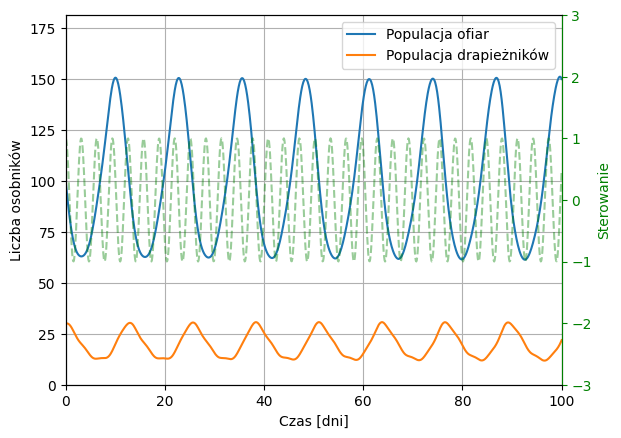

In [30]:
x0 = [100, 30]
sterowanie = 'cos'

# u = lambda t : sterowanie + 0*t
u = lambda t : np.cos(2*t)
x, _ = generate_population_data(t, x0, u)

plt.plot(t, x[:, 0])
plt.plot(t, x[:, 1])
plt.ylim(0, max(x[:, 0]*1.2))
plt.xlim(0, max(t))
plt.grid()
plt.legend(["Populacja ofiar", "Populacja drapieżników"])
plt.xlabel("Czas [dni]")
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.spines['right'].set_color('green')
ax2.set_ylim(-3, 3)
ax2.yaxis.label.set_color('green')
ax2.tick_params(axis='y', colors='green')
ax2.plot(t, u(t), 'g--', alpha=0.4)
ax2.set_ylabel("Sterowanie")
ax1.set_ylabel("Liczba osobników")
ax2.set_ylabel("Sterowanie")
plt.savefig(f'imgs/proces-1-nieaut-{x0[0]}-{x0[1]}_{sterowanie}.png', dpi=300, bbox_inches='tight')
plt.show()